<a href="https://colab.research.google.com/github/angnat/JupyterNotebook/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow Part 3: Scaling up

Our baseline to beat is 50.76% accuracy accross 101 clases

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Thu May  9 14:18:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Create helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-09 14:18:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-09 14:18:59 (43.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper function for our notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data


In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-09 14:19:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  20.8MB/s    in 77s     

2024-05-09 14:20:23 (20.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250

In [6]:
#Setup data input
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode='categorical',
                                                                                image_size=IMG_SIZE,
                                                                                shuffle=False) #don't shuffle for prediction analysist


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning

Step:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data
* Build a headless (no top layers) Functionl EfficientNetB0 (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on train dataset and validation 15% of the test data, to save epoch)

In [7]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint_callback'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
   # preprocessing.Rescaling(1/255.) # rescle inputs of image to between 0 & 1
],name='data_augmentation')

In [9]:
# Setup the base model and freeze it's layers
base_model =  tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs) # augment images
x = base_model(x, training=False) # put base model in inferance mode so weight stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)



24274472/24274472 [==============================] - 1s 0us/step


In [10]:
# Get a Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
history_all_classess_10_percent = model.fit(train_data_all_10_percent,
    epochs=5,
          validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)), #validasi hanya menggunakan 15% data
          callbacks=[checkpoint_callback]

)

Epoch 1/5
237/237 [==============================] - 45s 137ms/step - loss: 3.4539 - accuracy: 0.2487 - val_loss: 2.6497 - val_accuracy: 0.4378
Epoch 2/5
237/237 [==============================] - 28s 116ms/step - loss: 2.3219 - accuracy: 0.4719 - val_loss: 2.1602 - val_accuracy: 0.4995
Epoch 3/5
237/237 [==============================] - 28s 115ms/step - loss: 1.9277 - accuracy: 0.5463 - val_loss: 1.9523 - val_accuracy: 0.5265
Epoch 4/5
237/237 [==============================] - 28s 115ms/step - loss: 1.7040 - accuracy: 0.5950 - val_loss: 1.8581 - val_accuracy: 0.5334
Epoch 5/5
237/237 [==============================] - 25s 105ms/step - loss: 1.5658 - accuracy: 0.6174 - val_loss: 1.8049 - val_accuracy: 0.5421


In [20]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 53s 66ms/step - loss: 1.5404 - accuracy: 0.6095


[1.54044771194458, 0.6094653606414795]

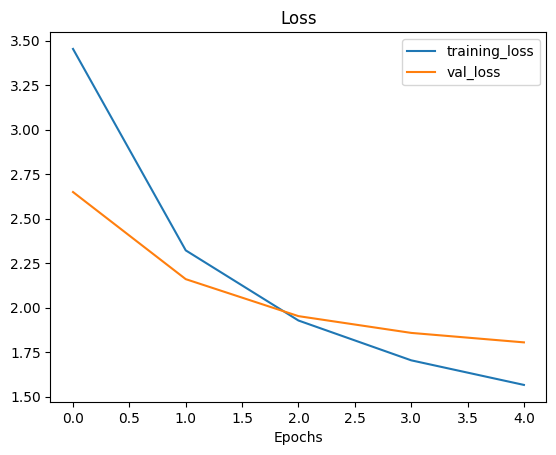

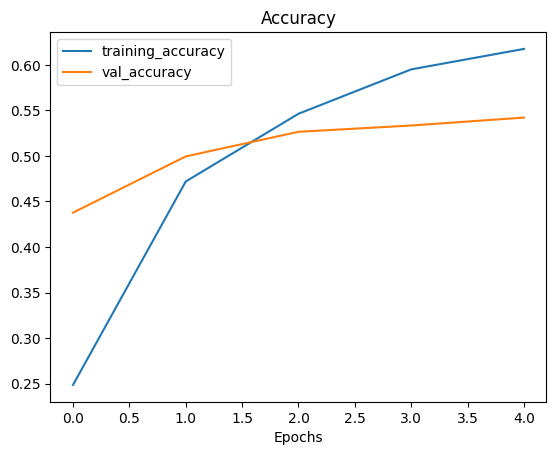

In [13]:
plot_loss_curves(history_all_classess_10_percent)

## Fine tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [15]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [16]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool True
output_layer True


In [17]:
# Check which layers are trainable in our base models
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)


0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [18]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10 # model sudah mempunyai 5 epochs dan fine tune lagi 5 epochs lagi

# Fine tune our model
history_all_classess_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tune_epochs,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      initial_epoch=history_all_classess_10_percent.epoch[-1] # -1 untuk continue dari yg terakhir
                                                      )

Epoch 5/10
237/237 [==============================] - 37s 120ms/step - loss: 1.4941 - accuracy: 0.6021 - val_loss: 1.7174 - val_accuracy: 0.5410
Epoch 6/10
237/237 [==============================] - 25s 103ms/step - loss: 1.1951 - accuracy: 0.6787 - val_loss: 1.8136 - val_accuracy: 0.5286
Epoch 7/10
237/237 [==============================] - 24s 101ms/step - loss: 1.0341 - accuracy: 0.7188 - val_loss: 1.8500 - val_accuracy: 0.5297
Epoch 8/10
237/237 [==============================] - 27s 113ms/step - loss: 0.8713 - accuracy: 0.7621 - val_loss: 1.7386 - val_accuracy: 0.5585
Epoch 9/10
237/237 [==============================] - 28s 117ms/step - loss: 0.7755 - accuracy: 0.7853 - val_loss: 1.7800 - val_accuracy: 0.5553
Epoch 10/10
237/237 [==============================] - 28s 116ms/step - loss: 0.6689 - accuracy: 0.8147 - val_loss: 1.6654 - val_accuracy: 0.5763


In [19]:
# Evaluate on the whole test data
all_classess_10_percent_fine_tune_results = model.evaluate(test_data)
all_classess_10_percent_fine_tune_results

790/790 [==============================] - 55s 69ms/step - loss: 1.5404 - accuracy: 0.6095


[1.54044771194458, 0.6094653606414795]

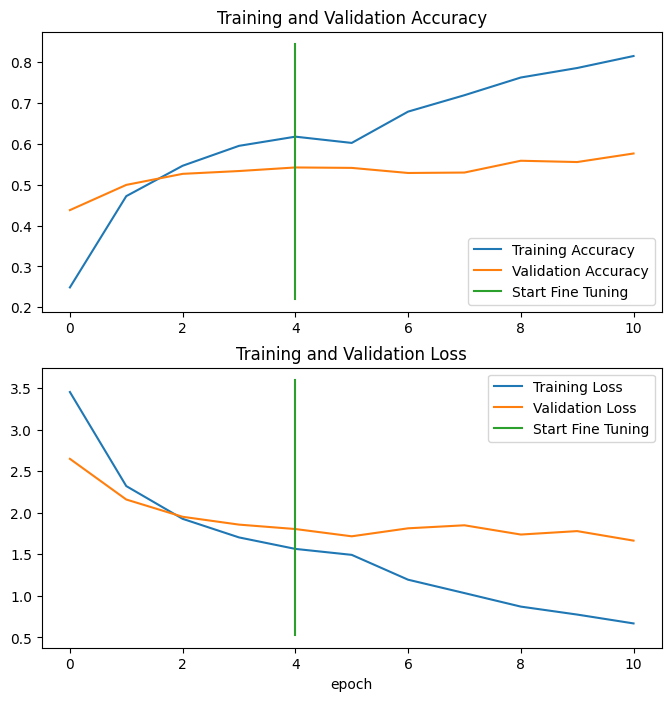

In [21]:
# Compare the histories feature ext model with fine tuning model
compare_historys(original_history=history_all_classess_10_percent,
                 new_history=history_all_classess_10_percent_fine_tune,
                 initial_epochs=5)